<h1> PROJECT MACHINE LEARNING </h1>

<h4> Import the necessary packages </h4>

In [1]:
import numpy as np
import pandas as pd
import joblib

import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

<h4> Define the file path of the csv data file </h4>

In [2]:
file_path = "../Dataset/books.csv"

<h2> Data Transformation part </h2>

In [3]:
books = pd.read_csv(file_path, sep=',')
test = pd.read_csv(file_path, sep=',')

In [4]:
# gets the data type of each column
books.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

<h4> Rename the num_pages column </h4>

In [5]:
books.rename(columns={"  num_pages": "num_pages"}, inplace=True)

In [6]:
books.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

<h4> Search for invalide date and turn it to NaT </h4>

In [7]:
try:
    # Convert the 'publication_date' column to datetime with 'coerce' option to handle invalid dates
    books['publication_date'] = pd.to_datetime(books['publication_date'], errors='coerce')
    
    # Find rows with invalid dates
    invalid_dates = books[books['publication_date'].isnull()]
    
    # Print the rows with invalid dates
    print(invalid_dates[['bookID', 'average_rating', 'publication_date']])
    
except Exception as e:
    print(e)

       bookID  average_rating publication_date
8180    31373            4.10              NaT
11098   45531            3.96              NaT


In [8]:
new_types_dict = {"title":"string", "authors":"string", "language_code":"category", "publisher":"category","isbn":"string", "isbn13":"string","average_rating":"float64","num_pages":"int64", "ratings_count":"int64","text_reviews_count":"int64","publication_date": "datetime64[ns]"}

# turn the books dataframe into a dataframe with the new types
books = books.astype(new_types_dict)
books.dtypes

bookID                         int64
title                         string
authors                       string
average_rating               float64
isbn                          string
isbn13                        string
language_code               category
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                   category
dtype: object

<h4> Make language code lowercase to be consistent </h4>

In [9]:
books["language_code"] = books["language_code"].str.lower()

# print all values of books["language_code"] distinct with their occurence count
books["language_code"].value_counts()

eng      8911
en-us    1409
spa       218
en-gb     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-ca       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: language_code, dtype: int64

<p> We decided to only take the 7 most used languages, and leave out the rest of the books in order to shorten the number of different languages and to do a <b> One hot encoding </b> on the books' languages afterwards </p>

In [10]:
# Only keep the rows where the language is in the top 7 most common languages
books = books[books['language_code'].isin(['eng', 'en-us', 'spa', 'en-gb', 'fre', 'ger', 'jpn'])]

In [11]:
# print all values of books["language_code"] distinct with their occurence count
books["language_code"].value_counts()

eng      8911
en-us    1409
spa       218
en-gb     214
fre       144
ger        99
jpn        46
Name: language_code, dtype: int64

<h4> Verify if there are null values </h4>

In [12]:
books.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      2
publisher             0
dtype: int64

In [13]:
books[books['publication_date'].isnull()]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
8180,31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,0553575104,9780553575101,eng,718,10608,295,NaT,Bantam Books
11098,45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9782070323289,fre,640,15,2,NaT,Folio histoire


## Guiding questions

Before diving into data exploration, it's essential to frame some guiding questions based on the project's objectives. These questions help in focusing the analysis and ensuring that the exploration aligns with the end goal, which in this case is predicting a book's rating.

Given the project's objective, here are some guiding questions that can shape the data exploration:

#### 1. Target Variable Understanding:

- What is the distribution of the __average_rating__? Are there more high-rated books than low-rated ones, or vice versa?
- Are there any books with extremely low or high ratings that might be considered outliers?


#### 2. Feature Relationships:

- How does the number of pages (__num_pages__) relate to the book's average rating (__average_rating__)? Do longer books receive better ratings?
- Is there a relationship between the number of ratings (__ratings_count__) a book has and its average rating (__average_rating__)? 
- How does the number of text reviews (__text_reviews_count__) relate to the average rating (__average_rating__)?
- Is there a relationship between the publication year and the amount of books published per year?
- What are the 10 publishers with the more books published?


#### 3. Language and Ratings:

- Are books in certain languages (__language_code__) rated higher on average than others?
- Is the dataset biased towards books in a particular language?

<h2> Data Analysis part </h2>

The dataset contains 12 columns, based on the guiding questions, we focus on specific columns for data analysis approach, in order to have some meaningful insights in the initial breakdown. 

In [14]:
pd.options.display.float_format = '{:.2f}'.format
books.describe()[['average_rating', 'ratings_count', 'text_reviews_count']]

,average_rating,ratings_count,text_reviews_count
count,11041.00,11041.00,11041.00
mean,3.93,18068.83,545.71
std,0.35,112906.44,2585.80
min,0.00,0.00,0.00
25%,3.77,107.00,9.00
50%,3.96,757.00,47.00
75%,4.13,5036.00,241.00
max,5.00,4597666.00,94265.00


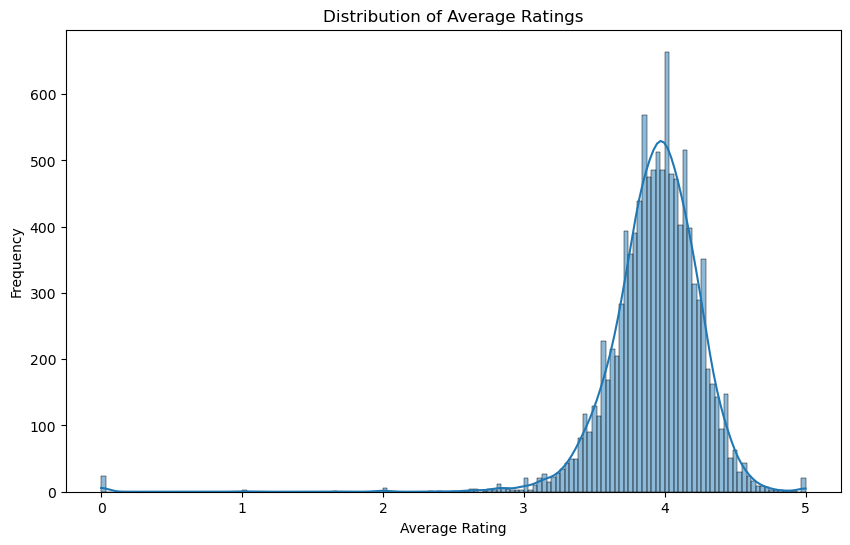

In [15]:
# Distribution of average_rating

plt.figure(figsize=(10, 6))
sns.histplot(books['average_rating'], kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

This histogram provides insights into the central tendency and spread of book ratings.

- __Observation__: The histogram peaks around a rating of 4, with a slight left skew.

- __Conclusion__: The majority of books in the dataset have ratings clustered around 4. The slight left skew indicates that there are more books with ratings just below 4 than just above. This suggests that while many books are well-received, a significant number receive moderately good ratings, with fewer books achieving near-perfect scores of 5.

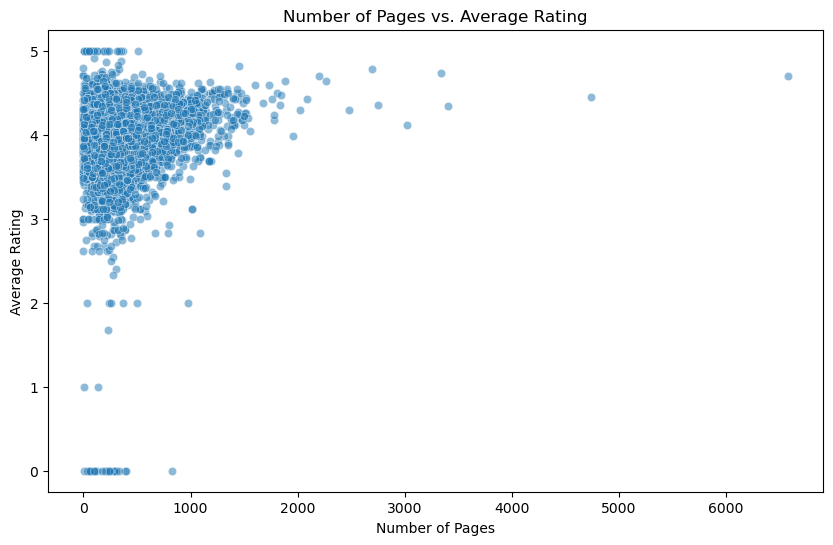

In [16]:
# Is there a relationship between "num_pages" vs. "average_rating"?

plt.figure(figsize=(10, 6))
sns.scatterplot(data=books, x='num_pages', y='average_rating', alpha=0.5)
plt.title('Number of Pages vs. Average Rating')
plt.xlabel('Number of Pages')
plt.ylabel('Average Rating')
plt.show()

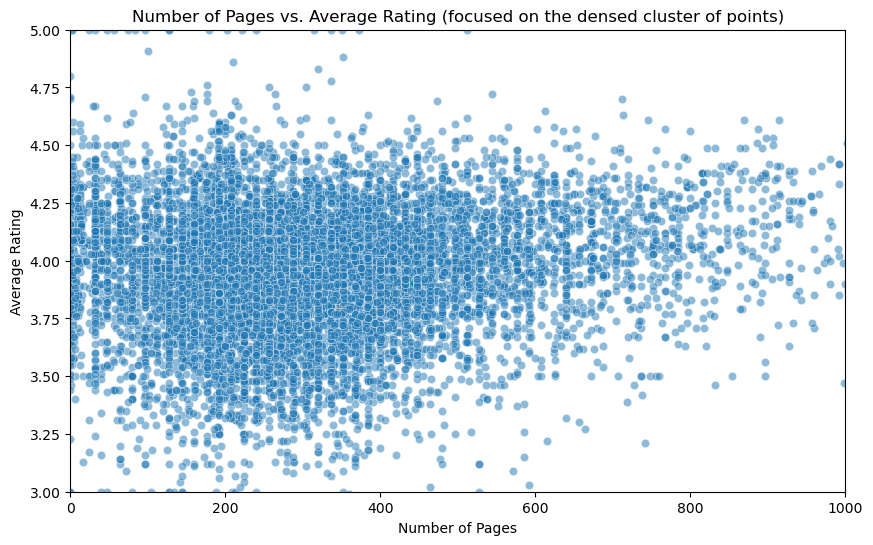

In [17]:
# Focus on the above densed part by plotting the focused region

plt.figure(figsize=(10, 6))
sns.scatterplot(data=books, x='num_pages', y='average_rating', alpha=0.5)
plt.title('Number of Pages vs. Average Rating (focused on the densed cluster of points)')
plt.xlabel('Number of Pages')
plt.ylabel('Average Rating')
plt.axis([0, 1000, 3, 5])
plt.show()

This scatter plot will help determine if there's a relationship between the length of a book and its average rating. A trend might suggest that readers prefer shorter or longer books.
- __Observation__: 
  + There's a dense cluster of points around 150-500 pages with ratings between 3.5 and 4.25.
  + Books beyond 800 pages show a wider spread in ratings.


- __Conclusion__: 
  + While books in the 150-500 page range tend to receive consistent ratings between 3.5 and 4.5, extremely lengthy books (beyond 800 pages) show a diverse range of ratings. This could indicate that reader reception for longer books is more polarized, with some finding them engrossing and others finding them tedious.
  + The result of this scatter plot suggests that book length and rating aren't strongly correlated.

/tmp/ipykernel_108182/2613302408.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = books[selected_columns].corr()


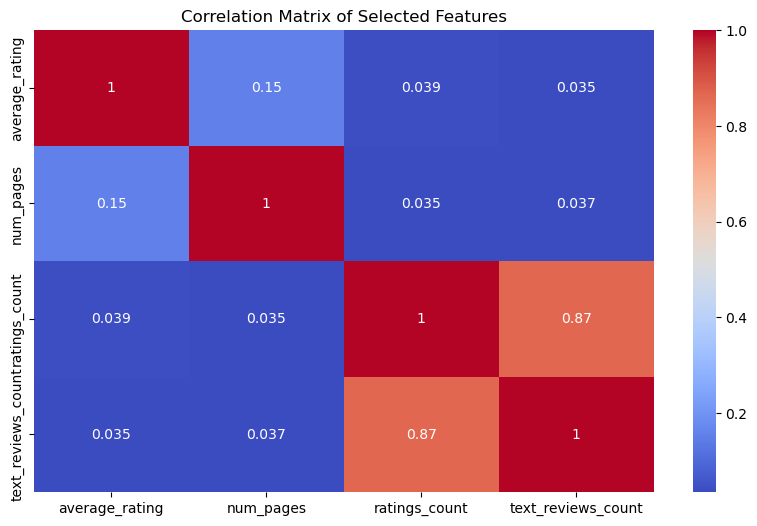

In [18]:
# Correlation Matrix of Selected Features

selected_columns = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count','publication_date']
correlation_matrix = books[selected_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()

- __Observation__: 'ratings_count' and 'text_reviews_count' have a correlation value of around 0.9, while 'average_rating' and 'num_pages' have a weak negative correlation with 'publication_year'.
- __Conclusion__: 
    + The strong correlation between 'ratings_count' and 'text_reviews_count' confirms that popular books, in terms of readership, also tend to receive more written feedback. 
    + However, the correlation value of -0.029 between 'average_rating' and 'publication_year' as well as -0.019 between 'num_pages' and 'publication_year' both indicate a very weak negative relationship. This suggests that while more recent books or longer books might have a slightly lower average rating, the difference is minimal and likely not of practical significance => It's crucial to consider other factors and not infer a direct causation based solely on this correlation.

<p> From the outputs above, we would like to have a scatter plot to see the relationship between the number of ratings and text reviews a book receives. </p>

In [19]:
px.scatter(data_frame=books,x='ratings_count',y='text_reviews_count',color='language_code',title='reviews_count vs text_reviews_count')

- __Observation__: There's a positive correlation between ratings_count and text_reviews_count, indicating that books with more ratings also tend to have more text reviews. However, some books with high ratings have disproportionately low text reviews.
- __Conclusion__: While books with a higher number of ratings tend to have more text reviews, there are exceptions. Some books, despite having high ratings, don't elicit as many written reviews. This could suggest that while many readers rate these books, fewer feel compelled to leave detailed feedback.

In [20]:
books.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [21]:
# Extract year from 'publication_date' and create a new 'year' column
books['publication_year'] = books['publication_date'].dt.year

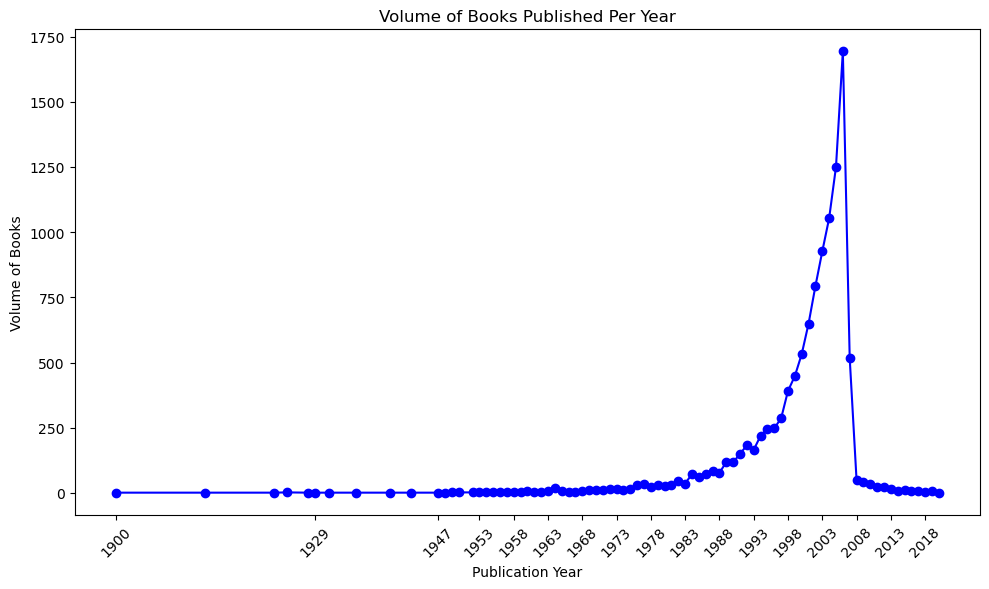

In [22]:
books['publication_year'] = pd.to_numeric(books['publication_year'])

# Group by 'publication_year' and count the number of books in each year
books_per_year = books.groupby('publication_year').size()

# Create a line chart to visualize the volumes of books per year
plt.figure(figsize=(10, 6))
plt.plot(books_per_year.index, books_per_year.values, marker='o', linestyle='-', color='b')
plt.xlabel('Publication Year')
plt.ylabel('Volume of Books')
plt.title('Volume of Books Published Per Year')
plt.xticks(books_per_year.index[::5], rotation=45)  # Set step size to display every five years
plt.tight_layout()
plt.show()

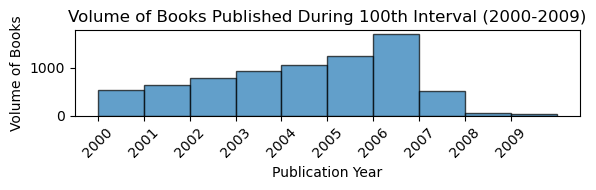

In [23]:
# Filter data for the 100th interval (2000-2009)
interval_100 = books[(books['publication_year'] >= 2000) & (books['publication_year'] <= 2009)]

# Create a histogram to visualize the volume of books in the 100th interval (2000-2009)
plt.figure(figsize=(6, 2))
plt.hist(interval_100['publication_year'], bins=10, range=(2000, 2010), edgecolor='black', alpha=0.7)
plt.xlabel('Publication Year')
plt.ylabel('Volume of Books')
plt.title('Volume of Books Published During 100th Interval (2000-2009)')
plt.xticks(range(2000, 2010), rotation=45)
plt.tight_layout()
plt.show()

- __Observation__:
    + From both graphs above, we see an ascending curve until beggining of 2007 of the quantity of books published per year.

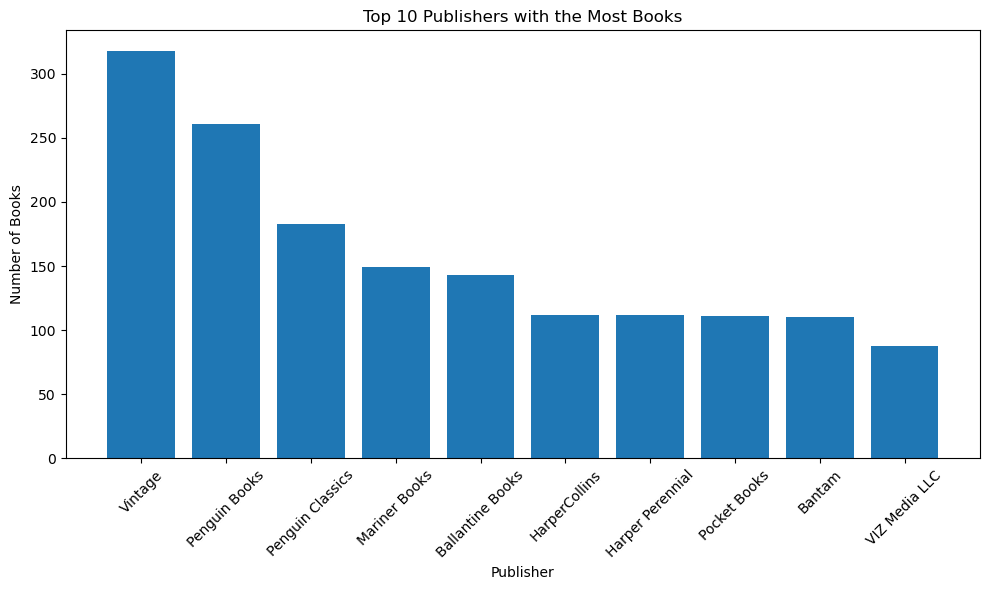

In [24]:
# Calculate the count of books for each publisher
publisher_counts = books['publisher'].value_counts()

# Sort the publishers based on book count in descending order
top_publishers = publisher_counts.head(10)

# Create a histogram for the top 10 publishers with the most books
plt.figure(figsize=(10, 6))
plt.bar(top_publishers.index, top_publishers.values)
plt.xlabel('Publisher')
plt.ylabel('Number of Books')
plt.title('Top 10 Publishers with the Most Books')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Quantity of books that belong to a series: 2365
Corresponding to 21% of the dataset


<Axes: xlabel='if_series', ylabel='average_rating'>

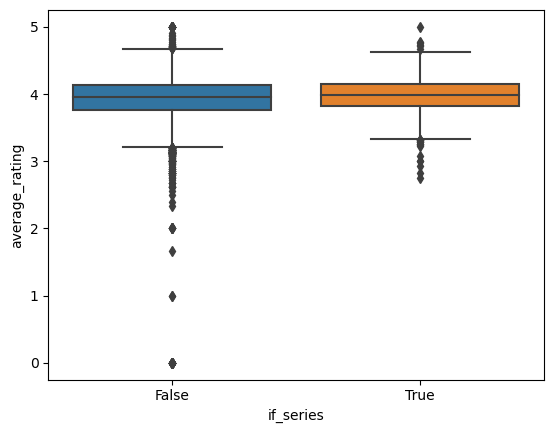

In [25]:
print(f"Quantity of books that belong to a series: {books['title'].str.contains('#').sum()}")
print("Corresponding to {}% of the dataset".format(round(100*books['title'].str.contains('#').sum()/books.shape[0])))

books['if_series'] = books['title'].str.contains('#')
sns.boxplot(data = books, x ="if_series", y ="average_rating")

- __Observation__:
    + A feature that tells us if the book belongs to a series of book or not. From the boxplot we can conclude that the median of books series is higher. However, its distribution its 4th quartile range has lower maximum average rating.

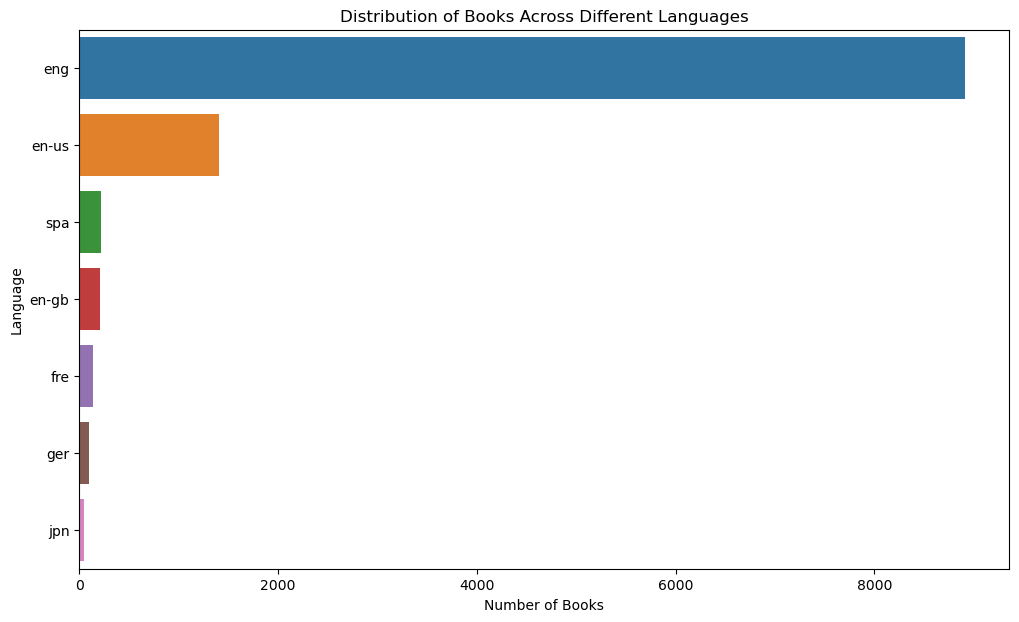

In [26]:
# "Language" distribution

plt.figure(figsize=(12, 7))
sns.countplot(data=books, y='language_code', order=books['language_code'].value_counts().index)
plt.title('Distribution of Books Across Different Languages')
plt.xlabel('Number of Books')
plt.ylabel('Language')
plt.show()

- __Observation__:
    + English ('eng') dominates the dataset by the tallest bar in the plot, with Spanish (spa) and German (ger) following but with significantly fewer books. A handful of languages like Japanese ('jpn') and German ('ger') are underrepresented in the dataset.
- __Conclusion__:
    + The dataset contains books from multiple languages, but it is predominantly composed of English books, reflecting the primary user base of Goodreads => However, this heavy bias towards English books might influence the predictive model, making it more tailored to patterns specific to English literature.
    + While Spanish and German books are also present, their numbers pale in comparison to English. Languages like Japanese and German are underrepresented, suggesting that the dataset might not capture the full spectrum of global literature => This limited representation might affect the model's ability to generalize predictions for books in these languages.

In [27]:
# Average rating vs. Ratings Count:

px.scatter(data_frame=books,x='average_rating',y='ratings_count',color='text_reviews_count',title='Average Rating vs Ratings Count')

<p> Here, we decided to remove some outliers to improve the dataset </p>

In [28]:
books = books[(books['text_reviews_count'] != 94265) & (books['average_rating'] != 3.59)]
books = books[(books['average_rating'] != 0 ) & (books['ratings_count'] != 0)]
books = books[(books['average_rating'] != 1 ) & (books['ratings_count'] != 1)]

In [29]:
px.scatter(data_frame=books,x='average_rating',y='ratings_count',color='text_reviews_count',title='Average Rating vs Ratings Count (outliers removed)')

### Insights from Data Visualization part:

__1. Distribution of Ratings:__

- The majority of books have ratings clustered around the 3.5 to 4.5 range. This indicates that most books in the dataset are well-received, but there's room for differentiation in predicting precise ratings.

__2. Language Distribution:__

- The dataset is predominantly composed of English books (eng). This suggests that the model might be more accurate for English books, and additional considerations or data might be needed for books in other languages.

__3.Correlation Insights:__

- There's a positive correlation between _ratings_count_ and _text_reviews_count_, indicating that books with more ratings also tend to have more text reviews.

__4. Outliers:__

- Some columns, like _ratings_count_ and _text_reviews_count_, have potential outliers that could skew predictive modeling. These outliers were addressed to ensure the model's robustness.

<h3> Analysis of the authors column </h3>

In [30]:
books["authors"].unique()

<StringArray>
[                                 'J.K. Rowling/Mary GrandPré',
                                                'J.K. Rowling',
                                      'W. Frederick Zimmerman',
                                               'Douglas Adams',
                                   'Douglas Adams/Stephen Fry',
                                                 'Bill Bryson',
                                              'J.R.R. Tolkien',
                                    'J.R.R. Tolkien/Alan  Lee',
               'Chris   Smith/Christopher  Lee/Richard Taylor',
                                                 'Jude Fisher',
 ...
                         'Stephen E. Ambrose/Barrett Whitener',
                                              'Sam R. Watkins',
                                            'Alexander Hunter',
                                    'Roald Dahl/Horacio Elena',
                                       'David Wood/Roald Dahl',
                     

<p> We can see that there are more than one authors working on a same book, the authors are separated by the slash symbol, so the best thing to do to valorize them is to duplicates the rows where there are many authors, and assign an unique author to each row (example, <b> Harry Potter and the Half blood Prince </b> is now duplicated into two lines, with the first line having the author as <b> J.K Rowling </b>, while the other one has <b> Mary GrandPré </b>) </p>

In [31]:
# Split authors and duplicate rows
new_rows = []
for index, row in books.iterrows():
    authors = row['authors'].split('/')
    for author in authors:
        new_row = row.copy()
        new_row['authors'] = author
        new_rows.append(new_row)

# Create a new DataFrame
books = pd.DataFrame(new_rows)

# Reset index
books.reset_index(drop=True, inplace=True)

In [32]:
books.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_year,if_series
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,2006.00,True
1,1,Harry Potter and the Half-Blood Prince (Harry ...,Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,2006.00,True
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2004.00,True
3,2,Harry Potter and the Order of the Phoenix (Har...,Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2004.00,True
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,2003.00,True


In [33]:
books["authors"].value_counts()

Stephen King           98
William Shakespeare    93
J.R.R. Tolkien         53
P.G. Wodehouse         47
Agatha Christie        47
                       ..
Isabel Margelí          1
Maja Ueberle-Pfaff      1
Billy Mills             1
Jodi Cobb               1
Michael Hemmingson      1
Name: authors, Length: 8974, dtype: int64

<h2> Machine Learning - Decision Tree Regressor</h2>

<p> Why did I choose to use Decision Tree? </p>
<ul>
    <li> Decision trees can capture complex relationships between features and the target </li>
    <li> It can handle both categorical and numerical features naturally. In our case, we have a mix of data types like "language_code", "publisher", "average_rating" and so on ... </li>
    <li> It is easy to implement </li>
    <li> I consider it as a "first step" for a more advanced method like Random Forest, should the need arise </li>
</ul>

In [34]:
books_decisionTree = books.copy()

In [35]:
books_decisionTree.index

RangeIndex(start=0, stop=18687, step=1)

In [36]:
# We find the missing indexes

full_range = set(range(len(books_decisionTree.index)))
missing_numbers = full_range - set(books_decisionTree.index)
print(f"There are {len(missing_numbers)} missing indexes")

missing_numbers_list = list(missing_numbers)
missing_numbers_list.sort()
for i in range(0, len(missing_numbers_list), 10):
    print(missing_numbers_list[i:i+10])

There are 0 missing indexes


In [37]:
drop_columns = ['bookID', 'title', 'isbn', 'isbn13', 'publication_date', 'publication_year', 'if_series']

books_decisionTree.drop(columns = drop_columns, inplace = True)

<h3> Feature engineering: </h3>

<ol>
    <li> Top 7 language codes earlier are encoded using the one hot method </li>
    <li> Label Encoding for publisher, since there are so many publishers, using One Hot Encoding would make the data set too heavy </li>
</ol>

In [38]:
# One hot encoding for language_codeS
books_decisionTree = pd.get_dummies(books_decisionTree, columns=["language_code"])

# Label encoding for 'publisher'
le = LabelEncoder()

books_decisionTree['publisher'] = le.fit_transform(books_decisionTree['publisher'])

# Drop the 'publisher' column
books_decisionTree.drop(columns=['publisher'], inplace=True)

# Label encoding for 'authors'
le = LabelEncoder()

books_decisionTree['authors_encoded'] = le.fit_transform(books_decisionTree['authors'])

# Drop the 'authors' column
books_decisionTree.drop(columns=['authors'], inplace=True)

In [39]:
# Splitting the dataset into training (80%) and testing (20%) sets
train_df, test_df = train_test_split(books_decisionTree, test_size=0.2, random_state=42)

In [40]:
# Define features and target variable
features = books_decisionTree.drop(columns=['average_rating'])
target = books_decisionTree['average_rating']

## Machine Learning - Decision Tree Regressor

In [41]:
# Initialize the Decision Tree regressor
regressor = DecisionTreeRegressor(random_state=42)

# Train the Decision Tree regressor
regressor.fit(train_df[features.columns], train_df['average_rating'])

# Make predictions on the test set
predictions = regressor.predict(test_df[features.columns])

In [42]:
# Calculate mean squared error
mse = mean_squared_error(test_df['average_rating'], predictions)
print(f"Mean Squared Error of Decision Tree Regressor: {mse:.2f}")

mae = mean_absolute_error(test_df['average_rating'], predictions)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(test_df['average_rating'], predictions)
print(f"R-squared: {r2:.2f}")

cv = np.std(predictions) / np.mean(predictions)
print(f"Coefficient of Variation: {cv:.2f}")

Mean Squared Error of Decision Tree Regressor: 0.09
Mean Absolute Error: 0.18
R-squared: -0.06
Coefficient of Variation: 0.08


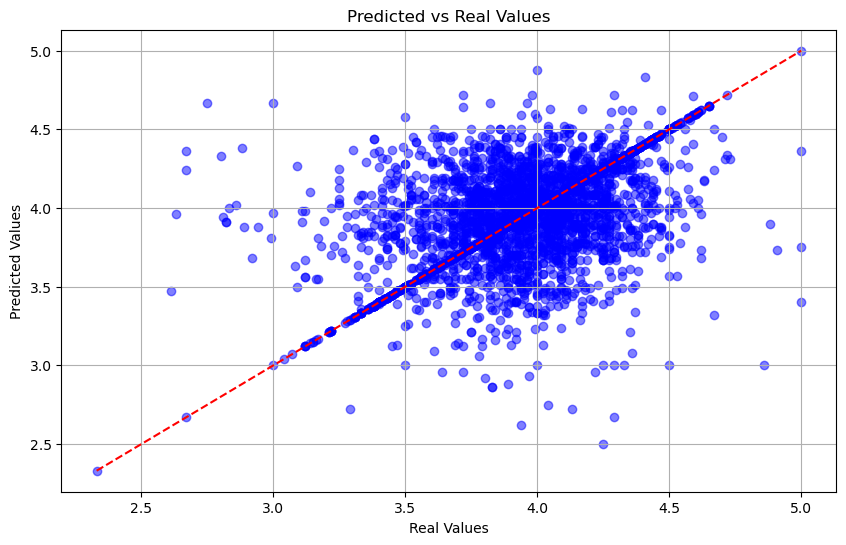

In [43]:
# Get the real values from the test set
real_values = test_df['average_rating']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(real_values, predictions, color='blue', alpha=0.5)
plt.title('Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Add a diagonal line for reference
x = np.linspace(min(real_values), max(real_values), 100)
plt.plot(x, x, color='red', linestyle='--')

plt.show()

<p> Judging from the plot above, we can see some promising results from the Decision Tree algorithm's output. However, there seem to be so much noise and so many outliers. The R-squared value being just 0.33 indicates that this is not a good fit for our data </p>

<p> From the result above, I decided to use the Random Forest Regressor algorithm, which builds multiple decision trees and combines their predictions to improve the overall performance of the model. It will reduce the impact of individual noisy or outlier-prone trees. This helps the model generalize better to new data, leading to improved accuracy on unseen instances. </p>

<h2> Machine Learning - Random Forest Regressor </h2>

In [44]:
books_randomForest = books.copy()

In [45]:
drop_columns = ['bookID', 'title', 'isbn', 'isbn13', 'publication_date','publication_year', 'if_series']

books_randomForest.drop(columns = drop_columns, inplace = True)

In [46]:
# One hot encoding for language_code
books_randomForest = pd.get_dummies(books_randomForest, columns=["language_code"])

# Label encoding for 'publisher'
le = LabelEncoder()

books_randomForest['publisher'] = le.fit_transform(books_randomForest['publisher'])

# Drop the 'publisher' column
books_randomForest.drop(columns=['publisher'], inplace=True)

# Label encoding for 'authors'
le = LabelEncoder()

books_randomForest['authors_encoded'] = le.fit_transform(books_randomForest['authors'])

# Drop the 'authors' column
books_randomForest.drop(columns=['authors'], inplace=True)

In [49]:
# Splitting the dataset into training (80%) and testing (20%) sets
train_df, test_df = train_test_split(books_randomForest, test_size=0.2, random_state=42)

# export the datasets for the deployment part
test_df.to_csv('test_df.csv')

# Define features and target variable
features = train_df.drop(columns=['average_rating'])
target = train_df['average_rating']

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(random_state=42)

# Train the model
random_forest.fit(features, target)

In [52]:
# Predict on the test set
test_features = test_df.drop(columns=['average_rating'])
predictions = random_forest.predict(test_features)

In [53]:
# Calculate mean squared error
mse = mean_squared_error(test_df['average_rating'], predictions)
print(f"Mean Squared Error of Random Forest Regressor: {mse:.2f}")

mae = mean_absolute_error(test_df['average_rating'], predictions)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(test_df['average_rating'], predictions)
print(f"R-squared: {r2:.2f}")

cv = np.std(predictions) / np.mean(predictions)
print(f"Coefficient of Variation: {cv:.2f}")

Mean Squared Error of Random Forest Regressor: 0.05
Mean Absolute Error: 0.15
R-squared: 0.44
Coefficient of Variation: 0.05


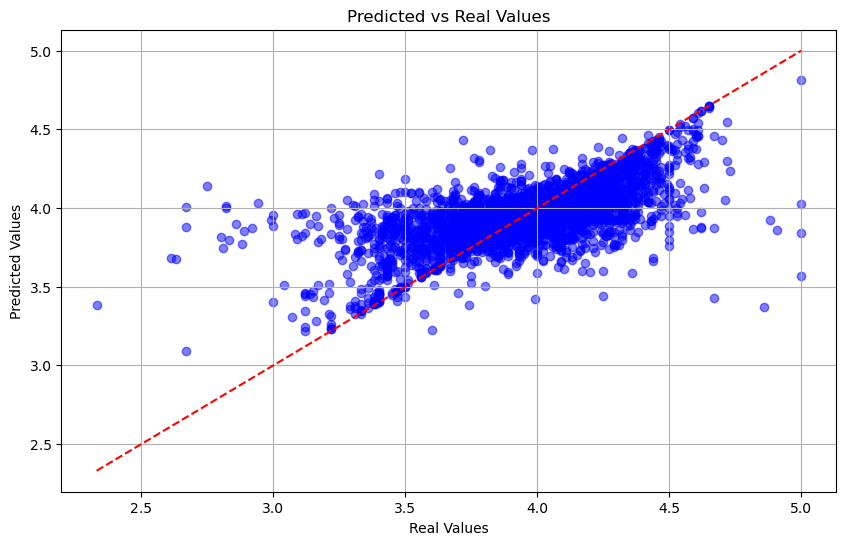

In [54]:
# Get the real values from the test set
real_values = test_df['average_rating']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(real_values, predictions, color='blue', alpha=0.5)
plt.title('Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Add a diagonal line for reference
x = np.linspace(min(real_values), max(real_values), 100)
plt.plot(x, x, color='red', linestyle='--')

plt.show()

From the statistics above, we can agree that this model is a better fit  for our dataset. The MSE, MAE and the coefficient of variation are all lower and with an acceptable value of R-Squared. So we would have an average rating with a prediction score of +- 0.15 of uncertainty.


Once the model chosen, we proceed to save it using the joblib module.

In [55]:
books_randomForest.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'language_code_en-gb', 'language_code_en-us', 'language_code_eng',
       'language_code_fre', 'language_code_ger', 'language_code_jpn',
       'language_code_spa', 'authors_encoded'],
      dtype='object')

In [ ]:
with open("random_forest.joblib","wb") as fout:
    model = joblib.dump(random_forest, fout)